In [6]:
# Import required libraries and modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque

############################################################################
# Generate a list of all possible species that may occur in this simulation
#
# Input:
# - max_len: the maximum polymer length in this simulation
# 
# Output:
# - species_list: list of all species of HP polymer from length 1 to max_len
############################################################################
def make_species_list(max_len):
    species_list = np.array(['H','P'])
    for i in range(1,max_len):
        for polymer in species_list[-(2**i):]:
            species_list = np.append(species_list, polymer + 'H')
            species_list = np.append(species_list, polymer + 'P')
    return (np.array(species_list))

#######################################################################################################################
# Make a list of all possible reactions that can occur in this simulation
# All stoichiometric coefficients are understood to be 1
# If there is only one reactant or product, we use None in the array's [1] or [3] position
#
# Inputs: 
# - species_list: numpy array of all species in the simulation
# - max_len: length of longest polymer that can occur in the simulation
# - forward_rate: rate constant for addition of monomer to a chain in absence of catalysis
# - backward_rate: rate constant for loss of monomer from a chain
# - cat_kt_per_hh: number to be multiplied by the length of a catalytic "landing pad" to calculate catalysis multiplier
#                  which is then multiplied by the base forward rate (forward_rate) to calculate rate with catalysis
#
# Output:
# - reactions: numpy array of possible reactions, with each reaction represented by a list consisting of 
#              [index in species_list of reactant 1, index in species_list of reactant 2, 
#              index in species_list of product 1, index in species_list of product 2, rate constant] 
#########################################################################################################################
def make_rxn_list(species_list, max_len, forward_rate, backward_rate, cat_kt_per_hh):
    reactions = deque()
    for i in range(len(species_list) - 2**max_len):
        modified_rxn_rate = get_rate(species_list[i], forward_rate, cat_kt_per_hh)
        reactions.append([i, 0, 2*i+2, None, modified_rxn_rate])
        reactions.append([i, 1, 2*i+3, None, forward_rate])
        reactions.append([2*i+2, None, i, 0, backward_rate])
        reactions.append([2*i+3, None, i, 1, backward_rate])
    return (np.array(reactions))

#######################################################################################################################
# Get a catalyzed rate or non-catalyzed rate constant
# 
# Inputs:
# - species: a string representing an HP polymer
# - forward_rate: rate constant for addition of monomer to a chain in absence of catalysis
# - backward_rate: rate constant for loss of monomer from a chain
# - cat_kt_per_hh: number to be multiplied by the length of a catalytic "landing pad" to calculate catalysis multiplier
#                  which is then multiplied by the base forward rate (forward_rate) to calculate rate with catalysis
#
# Output:
# - number representing the modified forward rate constant
#
# Note: cat_kt_per_hh = 0 will return forward_rate * e^0 = forward_rate
#
########################################################################################################################
def get_rate(species, forward_rate, cat_kt_per_hh):
    import math
    if species[-4:] == 'HHHH':
        return (forward_rate * math.exp(4 * cat_kt_per_hh))
    elif species[-3:] == 'HHH':
        return (forward_rate * math.exp(3 * cat_kt_per_hh))
    else:
        return (forward_rate)

###############################################################################################
# Initialize species populations as zero except for initial numbers of H and P monomers
#
# Inputs:
# - species_list: numpy array of strings representing all possible HP species in the simulation
# - init_h: initial number of H monomers in the system
# - init_p: initial number of P monomers in the system
#
# Outputs:
# - populations: numpy array of the same length as species_list; populations[i] is the 
#                population of species_list[i]
###############################################################################################
def initialize_populations(species_list, init_h, init_p):
    populations = np.zeros(len(species_list))
    populations[0] = init_h
    populations[1] = init_p
    return (populations)

#############################################################################
# Choose the next time and reaction by a Monte Carlo method
#
# Inputs:
# - A_total: sum of values in array A
# - A: numpy array of values such that A[i] is the propensity of reactions[i]
#
# Outputs:
# - tau: the time increment before the next reaction
# - mu: an integer such that reactions[mu] is the next reaction
#############################################################################
def choose_next_time_and_rxn(A_total,A):

    # Generate random numbers
    randoms = np.random.random(2)
    random_for_tau = randoms[0]
    random_for_mu = randoms[1]
    
    # Choose next time increment tau
    tau = (1 / A_total) * np.log(1 / random_for_tau)
    
    # Choose next reaction mu
    # Choose a point in the probability distribution representing a reaction mu, then search for it
    # To do this, decrement for each reaction until pointer reaches zero
    pointer = random_for_mu * A_total # Choose a point in the probability distribution
    mu = 0
    pointer -= A[mu]

    while pointer > 0:
        mu = mu + 1
        pointer -= A[mu]

    return (tau, mu)

#######################################################################################################################
# Run a Gillespie simulation
#
# Inputs:
# - max_len: maximum length of polymer
# - forward_rate: rate constant for addition of monomer to a chain in absence of catalysis
# - backward_rate: rate constant for loss of monomer from a chain
# - cat_kt_per_hh: number to be multiplied by the length of a catalytic "landing pad" to calculate catalysis multiplier
#                  which is then multiplied by the base forward rate (forward_rate) to calculate rate with catalysis
# - init_h: initial number of H monomers in the system
# - init_p: initial number of P monomers in the system
# - max_rxns: the maximum number of reactions to be run before a simulation ends
#
# Outputs:
# - species_list: numpy array of strings comprising all possible species in the simulation
# - reactions: numpy array of possible reactions, with each reaction represented by a list consisting of 
#              [index in species_list of reactant 1, index in species_list of reactant 2, 
#              index in species_list of product 1, index in species_list of product 2, rate constant]
# - store_times: a numpy array showing the time, in no particular units, at which each reaction occurred
# - store_populations: a numpy array containing the population of each species after every 1000 reactions
# - store_rxns: a numpy array containing the index in "reactions" of each successive reaction that occurred
# - final_populations: a numpy array containing the population of each species in species_list at the end of
#                      the simulation; final_populations[i] is the population of species_list[i]
#######################################################################################################################
def hp_gillespie_simulation(max_len, forward_rate, backward_rate, cat_kt_per_hh, init_h, init_p, max_rxns):
    
    ##################
    # Initialize lists
    ##################
    # Species list: each species is a string representing an HP polymer
    species_list = make_species_list(max_len)
    # Reactions: [reactant1, reactant2, product1, product2, rate]
    reactions = make_rxn_list(species_list, max_len, forward_rate, backward_rate, cat_kt_per_hh)
    # Current populations: curr_populations[i] is the population of species_list[i]
    curr_populations = initialize_populations(species_list, init_H, init_P)
    
    #############################################################################
    # Initialise the current time current_t and the reaction count rxn_count to 0
    #############################################################################
    curr_time = 0
    rxn_count = 0

    ##########################################################################
    # Initialise arrays to store time and species populations for trajectories
    ##########################################################################
    store_times = np.zeros(max_rxns + 1)
    store_populations = np.zeros((max_rxns//1000 + 1, len(species_list)))
    store_rxns = np.zeros(max_rxns + 1)

    ########################################
    # Store current time and state of system
    ########################################
    store_times[rxn_count] = curr_time
    store_populations[rxn_count,:] = curr_populations

    ######################################################################################################################
    # Main while loop: keep going until H or P monomer population reaches zero or we reach the maximum number of reactions
    ######################################################################################################################

    # Add monomers as necessary to stay near equilibrium
    while rxn_count < max_rxns:
        if (forward_rate * (curr_populations[0] + curr_populations[1])) < backward_rate:
            curr_populations[0] += 1
            curr_populations[1] += 1
        
        #####################################################################################################  
        # Calculate A[i] (product of reactant populations and rate) for each reaction, then calculate A_total
        # So A[i] is curr_populations[reactions[i][0]] * curr_populations[reactions[i][1]] * reactions[i][4]
        # Note that for degradations, reactions[i][1] will be None
        #####################################################################################################

        A_temp = deque()
        for i in range(len(reactions)):
            if reactions[i][0] == reactions[i][1]:
                A_temp.append(curr_populations[reactions[i][0]] * (curr_populations[reactions[i][1]] - 1) * reactions[i][4])
            elif reactions[i][1] is not None:
                A_temp.append(curr_populations[reactions[i][0]] * curr_populations[reactions[i][1]] * reactions[i][4])
            else:
                A_temp.append(curr_populations[reactions[i][0]] * reactions[i][4])
        A = np.array(A_temp)
        A_total = sum(A)
        
        ##########################################
        # Choose next time (tau) and reaction (mu)
        ##########################################
        tau, mu = choose_next_time_and_rxn(A_total,A)

        ##################################################################
        # Update the system (time, reaction count and species populations)
        ##################################################################
        curr_time += tau
        rxn_count += 1
        
        # keep track of what is going on
        if rxn_count % 5000 == 0:
            print ('rxn_count: ' + str(rxn_count))
            
        for i in range(2):
            if reactions[mu][i] is not None:
                curr_populations[reactions[mu][i]] -= 1
        for i in range(2,4):
            if reactions[mu][i] is not None:
                curr_populations[reactions[mu][i]] += 1

        ########################################################
        # Store the current system state for trajectory analysis
        # Store populations every 1000 reactions
        ########################################################
        store_times[rxn_count] = curr_time
        if rxn_count % 1000 == 0:
            store_populations[rxn_count//1000,:] = curr_populations 
        store_rxns[rxn_count] = mu
        
    # Store current populations as final populations
    final_populations = curr_populations

    # Get rid of empty positions in arrays
    store_times = store_times[:rxn_count]
    store_populations = store_populations[:rxn_count,:]
    store_rxns = store_rxns[:rxn_count]
    
    return species_list, reactions, store_times, store_populations, store_rxns, final_populations


rxn_count: 5000
rxn_count: 10000
rxn_count: 15000
rxn_count: 20000


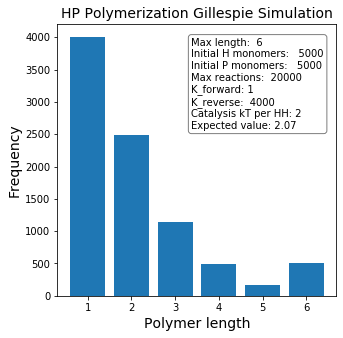

In [7]:
#########
# Example
#########

# Set parameters
max_len = 6
init_h = 5000
init_p = 5000
forward_rate = 1
backward_rate = 4000
cat_kt_per_hh = 2
max_rxns = 20000

# Run the program
species_list, reactions, store_times, store_populations, store_rxns, final_populations = \
hp_gillespie_simulation(max_len, forward_rate, backward_rate, cat_kt_per_hh, init_h, init_p, max_rxns)

# Calculate expected value
polymer_length_populations = [int(0) for x in range(max_len + 1)]
for i in range(len(species_list)):
    polymer_length_populations[len(species_list[i])] += int(final_populations[i])
expected_value = sum([i * polymer_length_populations[i] for i in range(1, max_len + 1)]) / sum(polymer_length_populations)

# Make the graph
fig = plt.figure(1, figsize=(5, 5))
ax = fig.add_subplot(111)
plt.bar([int(i) for i in range(1,max_len + 1)], polymer_length_populations[1:], align='center')
plt.xlabel('Polymer length', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('HP Polymerization Gillespie Simulation', fontsize = 14)

textstr = '\n'.join((
    'Max length: {:2.0f}'.format(max_len),
    'Initial H monomers: {:6.0f}'.format(init_H),
    'Initial P monomers: {:6.0f}'.format(init_P),
    'Max reactions: {:6.0f}'.format(max_rxns),
    'K_forward: {:1.0f}'.format(forward_rate),
    'K_reverse: {:5.0f}'.format(backward_rate), 
    'Catalysis kT per HH: {:1.0f}'.format(cat_kt_per_hh),
    'Expected value: {:4.2f}'.format(expected_value)))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.48, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)
plt.show()

# Save the figure
fig.savefig('gillespie_bar_graph.png', bbox_inches='tight')
